In [1]:
import sys
import os
from copy import deepcopy
sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from webapp.utils.azure_utils import KeyVault, DataLake
import dask.dataframe as dd
import dask.array as da
import river
from data_prep.prep import MeterDataSet

In [2]:
# Connect to Storage Account
vault = KeyVault(keyVaultName = "keyvaultdva2022")
storage_credential = vault.get_secret(secretName = "storagePrimaryKey")
storage = DataLake(account_name = "storageaccountdva", credential = storage_credential)

In [6]:
file_system = "energyhub"
norm_dir = "/data_parq/norm"
meters_dir = "/data_parq/meters"
meta_dir = "/data_parq/metadata"
weather_dir = "/data_parq/weather"
bad_building_dir = "/bad_buildings"

## Read in 1 building

In [4]:
file1 = "norm_Bear_assembly_Angel.parq"

In [7]:
df1 = storage.pandas_read(file_system, norm_dir, file1)

In [12]:
df1.columns

Index(['timestamp', 'building_id', 'electricity', 'site_id', 'sq_meter',
       'primary_space_usage', 'air_temperature', 'dew_temperature',
       'wind_direction', 'wind_speed', 'usage_lag1', 'usage_lag2',
       'usage_lag3', 'hour', 'weekday', 'month', 'year', 'weekday_hour', 'ts',
       'hour_x', 'hour_y', 'month_x', 'month_y', 'weekday_x', 'weekday_y'],
      dtype='object')

In [15]:
df1 = df1.drop(columns=['usage_lag1', 'usage_lag2',
       'usage_lag3'])

In [18]:
def usage_lag (df, lag_col):
    df['usage_lag1'] = df[lag_col].shift(1)
    df['usage_lag2'] = df[lag_col].shift(2)
    df['usage_lag3'] = df[lag_col].shift(3)
    return df

In [19]:
df1 = usage_lag(df1, 'electricity')

In [23]:
df1[['timestamp', 'electricity','usage_lag1', 'usage_lag2','usage_lag3' ]].head()

,timestamp,electricity,usage_lag1,usage_lag2,usage_lag3
0,2016-01-01 00:00:00,237.85,NaN,NaN,NaN
1,2016-01-01 01:00:00,221.25,237.85,NaN,NaN
2,2016-01-01 02:00:00,222.50,221.25,237.85,NaN
3,2016-01-01 03:00:00,221.40,222.50,221.25,237.85
4,2016-01-01 04:00:00,224.25,221.40,222.50,221.25


<AxesSubplot:>

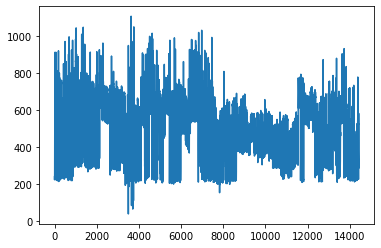

In [40]:
df1['electricity'].plot()

## River Stream

In [27]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import stream

In [28]:
X = df1.drop(columns = ['building_id', 'site_id', 'primary_space_usage']).dropna()
y = X.pop("electricity")

In [29]:

for xi, yi in stream.iter_pandas(X, y):
    print(xi, yi)
    break

{'timestamp': Timestamp('2016-01-01 03:00:00'), 'sq_meter': 22117.0, 'air_temperature': 4.4, 'dew_temperature': -7.8, 'wind_direction': 30.0, 'wind_speed': 2.6, 'hour': 3, 'weekday': 4, 'month': 1, 'year': 2016, 'weekday_hour': '4-3', 'ts': 3.0, 'hour_x': 0.7071067811865476, 'hour_y': 0.7071067811865476, 'month_x': 0.9996662829136674, 'month_y': 0.025832591925153667, 'weekday_x': 0.9937122098932426, 'weekday_y': 0.11196447610330786, 'usage_lag1': 222.5, 'usage_lag2': 221.25, 'usage_lag3': 237.85} 221.4


In [52]:
X_y = stream.iter_pandas(X, y)

model = compose.Select('sq_meter', 'air_temperature', 'dew_temperature',
       'wind_direction', 'wind_speed', 
       'month', 'weekday', 'hour',  
       'hour_x', 'hour_y','month_x','month_y','weekday_x','weekday_y',
       'usage_lag1', 'usage_lag2', 'usage_lag3')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(lr=0.003))

metric = metrics.R2()

evaluate.progressive_val_score(X_y, model, metric, print_every=24)


[24] R2: -0.229213
[48] R2: 0.16647
[72] R2: 0.455527
[96] R2: 0.537048
[120] R2: 0.583453
[144] R2: 0.615156
[168] R2: 0.642589
[192] R2: 0.657235
[216] R2: 0.668222
[240] R2: 0.689528
[264] R2: 0.703175
[288] R2: 0.712821
[312] R2: 0.703902
[336] R2: 0.704274
[360] R2: 0.705732
[384] R2: 0.710471
[408] R2: 0.710383
[432] R2: 0.720825
[456] R2: 0.725208
[480] R2: 0.727468
[504] R2: 0.729692
[528] R2: 0.733963
[552] R2: 0.720411
[576] R2: 0.716795
[600] R2: 0.719013
[624] R2: 0.719431
[648] R2: 0.725791
[672] R2: 0.728257
[696] R2: 0.733167
[720] R2: 0.734843
[744] R2: 0.728235
[768] R2: 0.730021
[792] R2: 0.732152
[816] R2: 0.735195
[840] R2: 0.738371
[864] R2: 0.739214
[888] R2: 0.74377
[912] R2: 0.743594
[936] R2: 0.746806
[960] R2: 0.747805
[984] R2: 0.750564
[1,008] R2: 0.75651
[1,032] R2: 0.759798
[1,056] R2: 0.763655
[1,080] R2: 0.762112
[1,104] R2: 0.76384
[1,128] R2: 0.765832
[1,152] R2: 0.766935
[1,176] R2: 0.768844
[1,200] R2: 0.771503
[1,224] R2: 0.770683
[1,248] R2: 0.7726

R2: 0.870598